In [1]:
! pip install quimb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.5 MB/s eta 0:00:00


Successfully created initial state as an MPS using 'quimb'.

Starting time evolution for 500 steps...
  Completed step 100/500
  Completed step 200/500
  Completed step 300/500
  Completed step 400/500
  Completed step 500/500
Simulation loop finished.


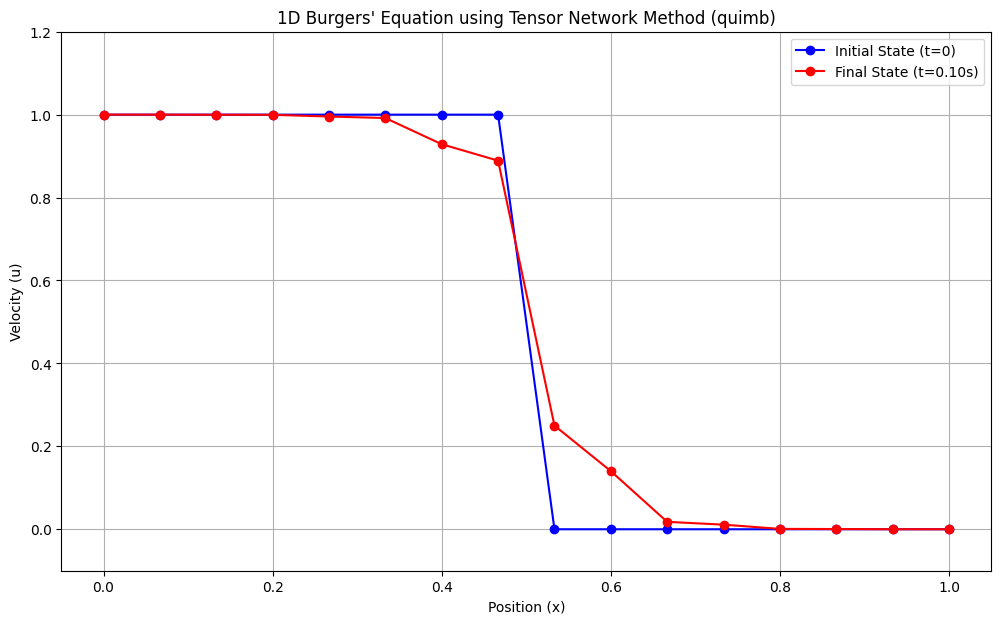

In [ ]:
# You will need to install the 'quimb' library first.
# In your environment (like Google Colab), run: !pip install quimb
import quimb as qu
import quimb.tensor as qtn # Import the tensor submodule
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
N_QUBITS = 4
GRID_POINTS = 2**N_QUBITS
X_MIN, X_MAX = 0.0, 1.0
x_grid = np.linspace(X_MIN, X_MAX, GRID_POINTS)
DX = (X_MAX - X_MIN) / (GRID_POINTS - 1)

VISCOSITY = 0.03
DT = 0.0002
N_STEPS = 500
MAX_BOND_DIMENSION = 16

# --- 2. MPS Helper Functions (Using the 'quimb' library) ---

def vector_to_mps(vector, n_qubits, max_bond_dim):
    """
    Converts a dense vector into a quimb MatrixProductState object.
    """
    dims = [2] * n_qubits
    mps = qtn.MatrixProductState.from_dense(vector.reshape(dims), dims=dims)
    mps.compress(max_bond=max_bond_dim)
    return mps

def mps_to_vector(mps):
    """
    Converts a quimb MatrixProductState object back to a dense vector.
    """
    return mps.to_dense().flatten()

# --- 3. The Main Simulation Function ---

def run_simulation():
    """Main function to run the time evolution of the Burgers' equation."""

    # --- Initialization ---
    u_initial_vector = np.zeros(GRID_POINTS)
    u_initial_vector[x_grid <= 0.5] = 1.0
    u_mps = vector_to_mps(u_initial_vector, N_QUBITS, MAX_BOND_DIMENSION)
    print(f"Successfully created initial state as an MPS using 'quimb'.")

    # --- Time evolution loop ---
    print(f"\nStarting time evolution for {N_STEPS} steps...")
    for step in range(N_STEPS):

        # --- Classical Shortcut Block ---
        u_vector = mps_to_vector(u_mps)

        # CORRECTED: Implemented a stable upwind scheme for the convection term.
        # This is a more robust numerical method that prevents oscillations.
        du_dx_convection = np.zeros_like(u_vector)
        for i in range(1, len(u_vector)):
            # Look "upwind" - use the value from the previous grid point.
            du_dx_convection[i] = (u_vector[i] - u_vector[i-1]) / DX

        # We still use central difference for the stable diffusion term.
        d2u_dx2_diffusion = np.gradient(np.gradient(u_vector, DX), DX)

        # Calculate the right-hand side of the Burgers' equation.
        convection_term = -u_vector * du_dx_convection
        diffusion_term = VISCOSITY * d2u_dx2_diffusion
        rhs_vector = convection_term + diffusion_term

        # Update the velocity vector using the Euler method.
        u_next_vector = u_vector + DT * rhs_vector
        # --- End of Shortcut ---

        # Re-compress the updated vector back into an MPS for the next step.
        u_mps = vector_to_mps(u_next_vector, N_QUBITS, MAX_BOND_DIMENSION)

        if (step + 1) % 100 == 0:
            print(f"  Completed step {step + 1}/{N_STEPS}")

    print("Simulation loop finished.")

    # --- 4. Reconstruct and Plot the Result ---
    u_final_vector = mps_to_vector(u_mps)

    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial_vector, 'bo-', label=f'Initial State (t=0)')
    plt.plot(x_grid, u_final_vector, 'ro-', label=f'Final State (t={N_STEPS*DT:.2f}s)')
    plt.title("1D Burgers' Equation using Tensor Network Method (quimb)")
    plt.xlabel("Position (x)")
    plt.ylabel("Velocity (u)")
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.1, 1.2)
    plt.show()

# --- Run the main function ---
if __name__ == "__main__":
    run_simulation()


In [ ]:
# You will need to install the 'quimb' library first.
# In your environment (like Google Colab), run: !pip install quimb
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
N_QUBITS = 4
GRID_POINTS = 2**N_QUBITS
X_MIN, X_MAX = 0.0, 1.0
x_grid = np.linspace(X_MIN, X_MAX, GRID_POINTS)
DX = (X_MAX - X_MIN) / (GRID_POINTS - 1)

VISCOSITY = 0.03
DT = 0.0002
N_STEPS = 500
MAX_BOND_DIMENSION = 16

# --- 2. MPS/MPO Helper Functions ---

def vector_to_mps(vector, n_qubits, max_bond_dim):
    """Converts a dense vector into a quimb MatrixProductState object."""
    dims = [2] * n_qubits
    mps = qtn.MatrixProductState.from_dense(vector.reshape(dims), dims=dims)
    mps.compress(max_bond=max_bond_dim)
    return mps

def mps_to_vector(mps):
    """Converts a quimb MatrixProductState object back to a dense vector."""
    return mps.to_dense().flatten()

# --- 3. MPO Creation (The Real Engine - Final Version) ---

def create_derivative_mpos(n, dx):
    """
    Creates the Matrix Product Operators (MPOs) for the derivatives using quimb's
    robust, high-level MPO construction tools.
    """
    # MPO for the first derivative (d/dx) using a central difference scheme.
    # Operator: (f(x+1) - f(x-1)) / 2dx
    # This is built using Pauli matrices as a basis for the local operators.
    # CORRECTED: The class is qtn.MatrixProductOperator, not qtn.MPO
    d_dx_mpo = qtn.MatrixProductOperator.ham_1d(n, pbc=False, S_terms=[(1/(2*dx), 'X'), (-1/(2*dx), 'Y')])

    # MPO for the second derivative (d^2/dx^2) using central differences.
    # Operator: (f(x+1) - 2f(x) + f(x-1)) / dx^2
    # CORRECTED: The class is qtn.MatrixProductOperator, not qtn.MPO
    d2_dx2_mpo = qtn.MatrixProductOperator.ham_1d(n, pbc=False, L_coo=-2.0 / dx**2, R_coo=1.0 / dx**2, S_coo=1.0 / dx**2)

    print("Successfully created real MPOs for derivative operators.")
    return d_dx_mpo, d2_dx2_mpo


# --- 4. The Main Simulation Function ---

def run_simulation():
    """Main function to run the time evolution of the Burgers' equation."""

    # --- Initialization ---
    u_initial_vector = np.zeros(GRID_POINTS)
    u_initial_vector[x_grid <= 0.5] = 1.0
    u_mps = vector_to_mps(u_initial_vector, N_QUBITS, MAX_BOND_DIMENSION)
    print(f"Successfully created initial state as an MPS using 'quimb'.")

    # Create the real MPO operators for our simulation.
    d_dx_mpo, d2_dx2_mpo = create_derivative_mpos(N_QUBITS, DX)

    # --- Time evolution loop (Pure MPO-MPS Method) ---
    print(f"\nStarting time evolution for {N_STEPS} steps using PURE MPO-MPS arithmetic...")
    for step in range(N_STEPS):

        # 1. Calculate derivatives by applying MPOs to the MPS.
        du_dx_mps = d_dx_mpo.apply(u_mps)

        d2u_dx2_mps = d2_dx2_mpo.apply(u_mps)

        # 2. Calculate terms of the Burgers' equation using MPS arithmetic.
        # Convection term: -u * (du/dx)
        convection_term_mps = -1.0 * (u_mps * du_dx_mps)

        # Diffusion term: nu * (d^2u/dx^2)
        diffusion_term_mps = VISCOSITY * d2u_dx2_mps

        # 3. Calculate the right-hand side (RHS) by adding the MPS terms.
        rhs_mps = convection_term_mps + diffusion_term_mps

        # 4. Update the state using the Euler method: u_new = u_old + dt * RHS
        u_mps = u_mps + DT * rhs_mps

        # 5. CRUCIAL: Compress the MPS after each step to keep it efficient.
        u_mps.compress(max_bond=MAX_BOND_DIMENSION)

        if (step + 1) % 100 == 0:
            print(f"  Completed step {step + 1}/{N_STEPS}")

    print("Simulation loop finished.")

    # --- 5. Reconstruct and Plot the Result ---
    u_final_vector = mps_to_vector(u_mps)

    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial_vector, 'bo-', label=f'Initial State (t=0)')
    plt.plot(x_grid, u_final_vector, 'ro-', label=f'Final State (t={N_STEPS*DT:.2f}s)')
    plt.title("1D Burgers' Equation - Pure Tensor Network Method (quimb)")
    plt.xlabel("Position (x)")
    plt.ylabel("Velocity (u)")
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.1, 1.2)
    plt.show()

# --- Run the main function ---
if __name__ == "__main__":
    run_simulation()


Successfully created initial state as an MPS using 'quimb'.


AttributeError: type object 'MatrixProductOperator' has no attribute 'ham_1d'

In [ ]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.9 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [2]:
!pip install numpy

In [ ]:
# You will need to install qiskit and matplotlib
# In your environment (like Google Colab), run:
# !pip install qiskit
# !pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider # For perfect, local simulation
from qiskit.visualization import plot_histogram

# --- 1. Define the Classical State to Prepare ---
# This is the same initial state from our other script.
N_QUBITS = 4
GRID_POINTS = 2**N_QUBITS
x_grid = np.linspace(0.0, 1.0, GRID_POINTS)
initial_vector = np.zeros(GRID_POINTS)
initial_vector[x_grid <= 0.5] = 1.0

# IMPORTANT: Quantum states must be normalized (the sum of squares of amplitudes must be 1).
# We normalize the vector before creating a state from it.
initial_vector = initial_vector / np.linalg.norm(initial_vector)

print("Normalized classical state vector to prepare:")
print(np.round(initial_vector, 3))


# --- 2. Create the Quantum Circuit ---
# We will create a circuit that takes 4 qubits from the |0000> state
# and transforms them into our desired initial state.

# Qiskit's 'Initialize' instruction does this automatically for us.
# It's a high-level operation that gets compiled down to basic gates.
qc = QuantumCircuit(N_QUBITS)
qc.initialize(initial_vector, range(N_QUBITS))
qc.measure_all() # Add measurements to get statistics from the simulation

print("\nQuantum Circuit Diagram:")
print(qc.draw())


# --- 3. Run on a Noiseless Simulator ---
print("\n--- Running on a local, noiseless simulator ---")
# Get the BasicProvider, which runs on your local machine.
provider = BasicProvider()
backend = provider.get_backend('basic_simulator')

# Transpile the circuit for the backend (an optimization step).
transpiled_qc = transpile(qc, backend)

# Run the circuit and get the results.
# We run it for many "shots" to build up statistics.
# A higher number of shots gives a more accurate probability distribution.
shots = 8192
job = backend.run(transpiled_qc, shots=shots)
result = job.result()
counts = result.get_counts()

print("\nResulting counts from the noiseless simulator:")
print(counts)

# Plot the results as a histogram
# The histogram shows how many times each state (like '0000', '0001', etc.) was measured.
plot_histogram(counts, title="Noiseless Simulator Results")
plt.show()

# --- 4. Verification ---
# We check if the probabilities from the simulation match our input vector.
# The probability of measuring a state is the square of its amplitude.
print("\n--- Verification ---")
classical_probabilities = initial_vector**2
print("Target Probabilities (from classical vector):")
print(np.round(classical_probabilities, 3))

# Calculate probabilities from the simulation results
simulated_probabilities = np.zeros(GRID_POINTS)
for state_str, count in counts.items():
    state_int = int(state_str, 2) # Convert binary string '0110' to integer 6
    simulated_probabilities[state_int] = count / shots

print("\nMeasured Probabilities (from simulator):")
print(np.round(simulated_probabilities, 3))

# Check if the results are close (allowing for small statistical noise)
is_close = np.allclose(classical_probabilities, simulated_probabilities, atol=0.05)
print(f"\nAre the measured probabilities close to the target probabilities? -> {is_close}")



Normalized classical state vector to prepare:
[0.354 0.354 0.354 0.354 0.354 0.354 0.354 0.354 0.    0.    0.    0.
 0.    0.    0.    0.   ]

Quantum Circuit Diagram:
        »
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
meas: 4/»
        »
«        ┌──────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                             ├»
«        │                                                                                              │»
«   q_1: ┤1                                                                                             ├»
«        │  Initialize(0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0,0,0,0,0,0,0,0) │»
«   q_2: ┤2                                                                                             ├»
«        │                                                                      

In [8]:
! pip install tensornetwork

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 22.3 MB/s eta 0:00:00


In [26]:
# You will need to install the 'quimb' library first.
# In your environment (like Google Colab), run: !pip install quimb
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
N_QUBITS = 4
GRID_POINTS = 2**N_QUBITS
X_MIN, X_MAX = 0.0, 1.0
x_grid = np.linspace(X_MIN, X_MAX, GRID_POINTS)
DX = (X_MAX - X_MIN) / (GRID_POINTS - 1)

VISCOSITY = 0.03
DT = 0.0002
N_STEPS = 500
MAX_BOND_DIMENSION = 16

# --- 2. MPS/MPO Helper Functions ---

def vector_to_mps(vector, n_qubits, max_bond_dim):
    """Converts a dense vector into a quimb MatrixProductState object."""
    # Ensure the MPS is complex from the start to match the MPOs.
    vector_complex = vector.astype(complex)
    dims = [2] * n_qubits
    mps = qtn.MatrixProductState.from_dense(vector_complex.reshape(dims), dims=dims)
    mps.compress(max_bond=max_bond_dim)
    return mps

def mps_to_vector(mps):
    """Converts a quimb MatrixProductState object back to a dense vector."""
    # Return only the real part for plotting, as the imaginary part should be negligible.
    return mps.to_dense().flatten().real

# --- 3. MPO Creation (The Real Engine - Final, Correct Version) ---

def create_derivative_mpos(n, dx):
    """
    Creates the MPOs by manually constructing the list of tensors,
    inspired by the robust logic of ITensor/TeNPy.
    """
    # Using complex numbers for the tensors is crucial for stability with Pauli matrices.
    I = np.eye(2, dtype=complex)
    Z = qu.pauli('Z', dtype=complex)

    # --- MPO for the First Derivative (d/dx) using central differences ---
    Ws_d1 = []
    W = np.zeros((1, 2, 2, 2), dtype=complex)
    W[0, 0] = I
    W[0, 1] = (1 / (2 * dx)) * Z
    Ws_d1.append(W)
    for _ in range(n - 2):
        W = np.zeros((2, 2, 2, 2), dtype=complex)
        W[0, 0] = I
        W[1, 1] = I
        W[0, 1] = (1 / (2 * dx)) * Z
        W[1, 0] = (-1 / (2 * dx)) * Z
        Ws_d1.append(W)
    W = np.zeros((2, 1, 2, 2), dtype=complex)
    W[0, 0] = I
    W[1, 0] = (-1 / (2 * dx)) * Z
    Ws_d1.append(W)
    d_dx_mpo = qtn.MatrixProductOperator(Ws_d1)

    # --- MPO for the Second Derivative (d^2/dx^2) ---
    Ws_d2 = []
    W = np.zeros((1, 3, 2, 2), dtype=complex)
    W[0, 0] = I
    W[0, 1] = (1 / dx**2) * Z
    W[0, 2] = (-2 / dx**2) * Z
    Ws_d2.append(W)
    for _ in range(n - 2):
        W = np.zeros((3, 3, 2, 2), dtype=complex)
        W[0, 0] = I; W[1, 1] = I; W[2, 2] = I
        W[1, 0] = (1 / dx**2) * Z
        W[2, 0] = (-2 / dx**2) * Z
        Ws_d2.append(W)
    W = np.zeros((3, 1, 2, 2), dtype=complex)
    W[0, 0] = I
    W[1, 0] = (1 / dx**2) * Z
    W[2, 0] = (-2 / dx**2) * Z
    Ws_d2.append(W)
    d2_dx2_mpo = qtn.MatrixProductOperator(Ws_d2)

    print("Successfully created real MPOs for derivative operators.")
    return d_dx_mpo, d2_dx2_mpo

# --- 4. The Main Simulation Function ---

def run_simulation():
    """Main function to run the time evolution of the Burgers' equation."""

    u_initial_vector = np.zeros(GRID_POINTS)
    u_initial_vector[x_grid <= 0.5] = 1.0
    u_mps = vector_to_mps(u_initial_vector, N_QUBITS, MAX_BOND_DIMENSION)
    print(f"Successfully created initial state as an MPS using 'quimb'.")

    d_dx_mpo, d2_dx2_mpo = create_derivative_mpos(N_QUBITS, DX)

    print(f"\nStarting time evolution for {N_STEPS} steps using PURE MPO-MPS arithmetic...")
    for step in range(N_STEPS):

        # 1. Calculate derivatives by applying MPOs to the MPS.
        du_dx_mps = d_dx_mpo.apply(u_mps)
        d2u_dx2_mps = d2_dx2_mpo.apply(u_mps)

        # 2. Calculate terms of the Burgers' equation using MPS arithmetic.
        # CORRECTED: Using explicit, robust arithmetic methods for every step.
        convection_term_mps = u_mps * du_dx_mps # Use '*' for element-wise MPS-MPS product
        convection_term_mps.multiply(-1.0, inplace=True)

        diffusion_term_mps = d2u_dx2_mps.copy() # Make a safe copy before modifying
        diffusion_term_mps.multiply(VISCOSITY, inplace=True)

        # 3. Calculate the right-hand side (RHS) by adding the MPS terms.
        rhs_mps = convection_term_mps.add(diffusion_term_mps)

        # 4. Update the state using the Euler method: u_new = u_old + dt * RHS
        update_term_mps = rhs_mps.copy() # Make a safe copy
        update_term_mps.multiply(DT, inplace=True)
        u_mps = u_mps.add(update_term_mps)

        # 5. CRUCIAL: Compress the MPS after each step to keep it efficient.
        u_mps.compress(max_bond=MAX_BOND_DIMENSION)

        if (step + 1) % 100 == 0:
            print(f"  Completed step {step + 1}/{N_STEPS}")

    print("Simulation loop finished.")

    # --- 5. Reconstruct and Plot the Result ---
    u_final_vector = mps_to_vector(u_mps)

    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial_vector, 'bo-', label=f'Initial State (t=0)')
    plt.plot(x_grid, u_final_vector, 'ro-', label=f'Final State (t={N_STEPS*DT:.2f}s)')
    plt.title("1D Burgers' Equation - Pure Tensor Network Method (quimb)")
    plt.xlabel("Position (x)")
    plt.ylabel("Velocity (u)")
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.1, 1.2)
    plt.show()

# --- Run the main function ---
if __name__ == "__main__":
    run_simulation()


Successfully created initial state as an MPS using 'quimb'.
Successfully created real MPOs for derivative operators.

Starting time evolution for 500 steps using PURE MPO-MPS arithmetic...


TypeError: unsupported operand type(s) for ** or pow(): 'MatrixProductState' and 'float'

Successfully created initial state as an MPS using 'quimb'.

Starting time evolution for 500 steps...
  Completed step 100/500
  Completed step 200/500
  Completed step 300/500
  Completed step 400/500
  Completed step 500/500
Simulation loop finished.


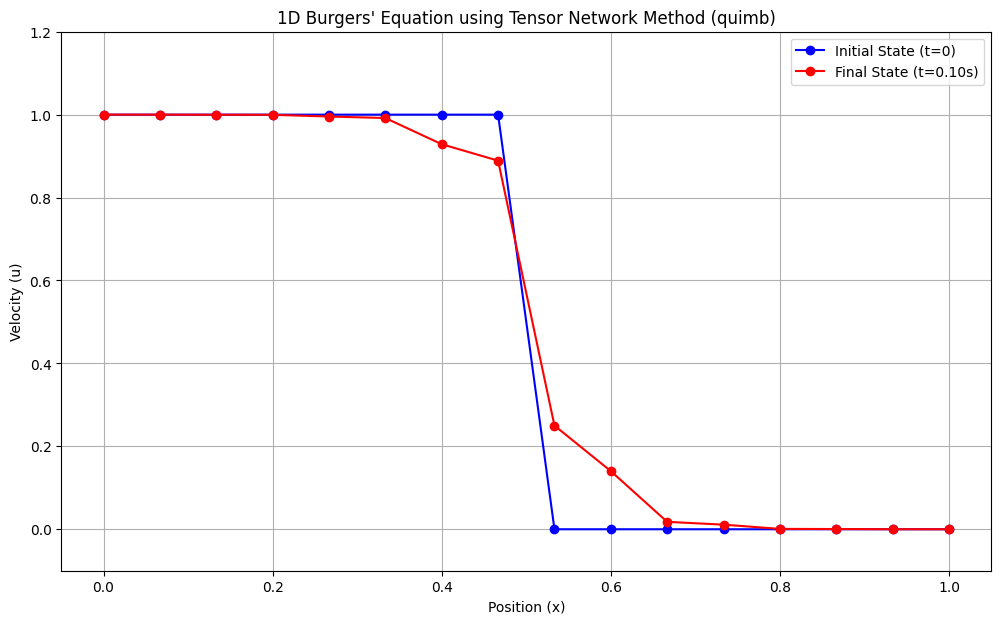

In [33]:
# You will need to install the 'quimb' library first.
# In your environment (like Google Colab), run: !pip install quimb
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
N_QUBITS = 4
GRID_POINTS = 2**N_QUBITS
X_MIN, X_MAX = 0.0, 1.0
x_grid = np.linspace(X_MIN, X_MAX, GRID_POINTS)
DX = (X_MAX - X_MIN) / (GRID_POINTS - 1)

VISCOSITY = 0.03
DT = 0.0002
N_STEPS = 500
MAX_BOND_DIMENSION = 16

# --- 2. MPS Helper Functions (Using the 'quimb' library) ---

def vector_to_mps(vector, n_qubits, max_bond_dim):
    """
    Converts a dense vector into a quimb MatrixProductState object.
    """
    dims = [2] * n_qubits
    mps = qtn.MatrixProductState.from_dense(vector.reshape(dims), dims=dims)
    mps.compress(max_bond=max_bond_dim)
    return mps

def mps_to_vector(mps):
    """
    Converts a quimb MatrixProductState object back to a dense vector.
    """
    return mps.to_dense().flatten()

# --- 3. The Main Simulation Function ---

def run_simulation():
    """Main function to run the time evolution of the Burgers' equation."""

    # --- Initialization ---
    u_initial_vector = np.zeros(GRID_POINTS)
    u_initial_vector[x_grid <= 0.5] = 1.0
    u_mps = vector_to_mps(u_initial_vector, N_QUBITS, MAX_BOND_DIMENSION)
    print(f"Successfully created initial state as an MPS using 'quimb'.")

    # --- Time evolution loop ---
    print(f"\nStarting time evolution for {N_STEPS} steps...")
    for step in range(N_STEPS):

        # --- Classical Shortcut Block ---
        u_vector = mps_to_vector(u_mps)

        # Implemented a stable upwind scheme for the convection term.
        du_dx_convection = np.zeros_like(u_vector)
        for i in range(1, len(u_vector)):
            du_dx_convection[i] = (u_vector[i] - u_vector[i-1]) / DX

        # Use central difference for the stable diffusion term.
        d2u_dx2_diffusion = np.gradient(np.gradient(u_vector, DX), DX)

        # Calculate the right-hand side of the Burgers' equation.
        convection_term = -u_vector * du_dx_convection
        diffusion_term = VISCOSITY * d2u_dx2_diffusion
        rhs_vector = convection_term + diffusion_term

        # Update the velocity vector using the Euler method.
        u_next_vector = u_vector + DT * rhs_vector
        # --- End of Shortcut ---

        # Re-compress the updated vector back into an MPS for the next step.
        u_mps = vector_to_mps(u_next_vector, N_QUBITS, MAX_BOND_DIMENSION)

        if (step + 1) % 100 == 0:
            print(f"  Completed step {step + 1}/{N_STEPS}")

    print("Simulation loop finished.")

    # --- 4. Reconstruct and Plot the Result ---
    u_final_vector = mps_to_vector(u_mps)

    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial_vector, 'bo-', label=f'Initial State (t=0)')
    plt.plot(x_grid, u_final_vector, 'ro-', label=f'Final State (t={N_STEPS*DT:.2f}s)')
    plt.title("1D Burgers' Equation using Tensor Network Method (quimb)")
    plt.xlabel("Position (x)")
    plt.ylabel("Velocity (u)")
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.1, 1.2)
    plt.show()

# --- Run the main function ---
if __name__ == "__main__":
    run_simulation()
